# Save yaml files for SIMCEO drivers

- TT7 Controller
- FSM Controller
- AZ, EL, and GIR Controller
- M2 Positioner (ad hoc) dynamic model
- State-space (SS) representation to merge M2 FEM and positioner outputs
- SS model to merge AcO bending mode corrections and the M1 support actuator forces

In [1]:
import numpy as np
import scipy.io as spio
#import scipy.linalg as la
from scipy import signal

import os
from os import path

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

### Load IMS data file with controllers and interface parameters

In [2]:
# The files with controller and interface models are available from the GMT-IMS repository
filepath = '/Users/rromano/Workspace/GMT-IMS/'
# filename = os.path.join(filepath,'controls_5pt1d_OAD.mat')
filename = os.path.join(filepath,'controls_5pt1d_dev.mat')

gmt_Ts = spio.loadmat(filename)['fem']['Ts'][0][0][0][0]
print('Telescope structural dynamics sampling frequency:%gHz'%(1/gmt_Ts))

Telescope structural dynamics sampling frequency:1000Hz


### Fast tip-tilt (TT) controller file (with PZT_cmd decoupled outputs)

In [3]:
# TT feedback controller (SS) model
tt7_fbC = spio.loadmat(filename)['tt7']['FBc_ss'][0][0][0][0]

print('Controller dimensions:',
      '\nA:',tt7_fbC['A'].shape,
      '\nB:',tt7_fbC['B'].shape,
      '\nC:',tt7_fbC['C'].shape,
      '\nD:',tt7_fbC['D'].shape)

tt7_ctrl_dt = {'System' :
               {'sampling time': gmt_Ts.tolist(), #second ,
                'parameters': {'A': tt7_fbC['A'].tolist(),
                               'B': (-tt7_fbC['B']).tolist(),
                               'C': (tt7_fbC['C']).tolist(),
                               'D': (-tt7_fbC['D']).tolist()}
               }}

if filename[-7:] == 'dev.mat':
    tt_yaml_file = 'TT_control_dev.yaml'
else:
    tt_yaml_file = 'TT_control_OAD.yaml'

if True:
    # Save fast TT controller yaml file
    with open(tt_yaml_file,'w') as f:
        y.dump(tt7_ctrl_dt, f)
    print('TT controller file saved as %s ' %tt_yaml_file)        

Controller dimensions: 
A: (56, 56) 
B: (56, 14) 
C: (14, 56) 
D: (14, 14)
TT controller file saved as TT_control_dev.yaml 


### M2 FSM feedback controller

In [4]:
fsm_fbC = spio.loadmat(filename)['mimo_fsmC'][0][0]
print('Controller dimensions:',
      '\nA:',fsm_fbC['A'].shape,
      '\nB:',fsm_fbC['B'].shape,
      '\nC:',fsm_fbC['C'].shape,
      '\nD:',fsm_fbC['D'].shape)

Controller dimensions: 
A: (168, 168) 
B: (168, 21) 
C: (21, 168) 
D: (21, 21)


Choose fast TT loop input as `segTT` for pseudo TT sensor simulations. Otherwise, choose `m2Rxy` to match the `M2TT` output from the `wfs24` object.

In [6]:
# Select fast_TT controller input: segment-TT or M2-RxRy:
# fastTT_in = 'segTT'
fastTT_in = 'm2Rxy'

# PZT commands decoupling matrix
if fastTT_in == 'segTT':
    pzt_dec_matrix = spio.loadmat(filename)['tt7']['TT2PZT'][0][0]
elif fastTT_in == 'm2Rxy':
    pzt_dec_matrix = spio.loadmat(filename)['tt7']['M2Rxy2PZT'][0][0]
else:
    pzt_dec_matrix = []
    print('Choose fastTT_in among segTT and m2Rxy!')

# Mapping from [r;y] to e (error signal)
Me = np.hstack((pzt_dec_matrix,
                np.kron(np.eye(7), np.hstack((np.eye(3),-np.eye(3))) ) ))
# Matrix to dristribute the PZT forces (mirror and cell sides)
Mu = np.kron(np.eye(7), np.vstack((-np.eye(3), np.eye(3))))

fsm_ctrl_dt = {'System' :
               {'sampling time': gmt_Ts.tolist(), #second ,
                'parameters': {'A': fsm_fbC['A'].tolist(),
                               'B': (fsm_fbC['B'] @ Me).tolist(),
                               'C': (Mu @ fsm_fbC['C']).tolist(),
                               'D': (Mu @ fsm_fbC['D'] @ Me).tolist()}
               }}

if filename[-7:] == 'dev.mat':
    fsm_yaml_file = 'FSM_control_dev.yaml'
else:
    fsm_yaml_file = 'FSM_control_OAD.yaml'

if True:
    # Save fast TT controller yaml file
    with open(fsm_yaml_file,'w') as f:
        y.dump(fsm_ctrl_dt, f)
    print('FSM controller file saved as %s ' %fsm_yaml_file)  

FSM controller file saved as FSM_control_dev.yaml 


### Mount controllers

In [7]:
mount_fbC = spio.loadmat(filename)['mount'][0]
print("Mount Ts:%0.3gs (%gHz)"%(mount_fbC[0][0],1/mount_fbC[0][0]))

# yaml filenames
az_yaml_file = 'AZ_fb_ssC.yaml'
el_yaml_file = 'EL_fb_ssC.yaml'
gir_yaml_file = 'GIR_fb_ssC.yaml'

Mount Ts:0.005s (200Hz)


#### Azimuth controller

In [8]:
az = mount_fbC[0][1][0][0]
az_fbC = az[0][0][0]
drv_radius = az[4]
print("AZ radius:%0.4gs"%drv_radius)
print('Controller dimensions:',
      '\nA:',az_fbC['A'].shape,
      '\nB:',az_fbC['B'].shape,
      '\nC:',az_fbC['C'].shape,
      '\nD:',az_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),np.hstack((np.ones((1,4)),-np.ones((1,4))))/4/drv_radius))

az_fbC_dt = {'System' :
               {'sampling time': mount_fbC[0][0][0][0].tolist(), #second ,
                'parameters': {'A': az_fbC['A'].tolist(),
                               'B': (az_fbC['B'] @ Me).tolist(),
                               'C': az_fbC['C'].tolist(),
                               'D': (az_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast AZ controller yaml file
    with open(az_yaml_file,'w') as f:
        y.dump(az_fbC_dt, f)
    print('Mount AZ controller file saved as %s ' %az_yaml_file)

AZ radius:9.493s
Controller dimensions: 
A: (7, 7) 
B: (7, 1) 
C: (1, 7) 
D: (1, 1)
Mount AZ controller file saved as AZ_fb_ssC.yaml 


#### Elevation controller

In [9]:
el = mount_fbC[0][2][0][0]
el_fbC = el[0][0][0]
drv_radius = el[4]
print("EL radius:%0.4gs"%drv_radius)
print('Controller dimensions:',
      '\nA:',el_fbC['A'].shape,
      '\nB:',el_fbC['B'].shape,
      '\nC:',el_fbC['C'].shape,
      '\nD:',el_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),np.hstack((np.ones((1,4)),-np.ones((1,4))))/4/drv_radius))

el_fbC_dt = {'System' :
               {'sampling time': mount_fbC[0][0][0][0].tolist(), #second ,
                'parameters': {'A': el_fbC['A'].tolist(),
                               'B': (el_fbC['B'] @ Me).tolist(),
                               'C': el_fbC['C'].tolist(),
                               'D': (el_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast EL controller yaml file
    with open(el_yaml_file,'w') as f:
        y.dump(el_fbC_dt, f)
    print('Mount EL controller file saved as %s ' %el_yaml_file)

EL radius:10.36s
Controller dimensions: 
A: (11, 11) 
B: (11, 1) 
C: (1, 11) 
D: (1, 1)
Mount EL controller file saved as EL_fb_ssC.yaml 


#### GIR controller

In [10]:
gir = mount_fbC[0][3][0][0]
gir_fbC = gir[0][0][0]
print("(!) For now, we not convert from ENC GIR to GIR angular displacement")
print('Controller dimensions:',
      '\nA:',gir_fbC['A'].shape,
      '\nB:',gir_fbC['B'].shape,
      '\nC:',gir_fbC['C'].shape,
      '\nD:',gir_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),np.hstack((np.ones((1,2)),-np.ones((1,2))))/2))

gir_fbC_dt = {'System' :
               {'sampling time': mount_fbC[0][0][0][0].tolist(), #second ,
                'parameters': {'A': gir_fbC['A'].tolist(),
                               'B': (gir_fbC['B'] @ Me).tolist(),
                               'C': gir_fbC['C'].tolist(),
                               'D': (gir_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast GIR controller yaml file
    with open(gir_yaml_file,'w') as f:
        y.dump(gir_fbC_dt, f)
    print('Mount GIR controller file saved as %s ' %gir_yaml_file)

(!) For now, we not convert from ENC GIR to GIR angular displacement
Controller dimensions: 
A: (6, 6) 
B: (6, 1) 
C: (1, 6) 
D: (1, 1)
Mount GIR controller file saved as GIR_fb_ssC.yaml 


### M2 Positioner (ad hoc) dynamic model

In [11]:
# 2nd order TF parameters
wn = 2*np.pi*2
zeta = 0.7
# CT TF
ctM2PosTF = signal.TransferFunction([wn**2], [1, 2*zeta*wn, wn**2])
M2PosTF = signal.cont2discrete((ctM2PosTF.num,ctM2PosTF.den), dt=5.0e-3, method='foh')
print('G(z):',M2PosTF[0][0],M2PosTF[1],'\n Ts:',M2PosTF[2])

M2Pos_adhoc_DynModel_dt = {'System' :{
    'sampling time': M2PosTF[2], 
    'parameters': { 'num': M2PosTF[0][0].tolist(),
                    'denom': M2PosTF[1][:].tolist()}
               }}
m2Pos_yaml_file = 'M2Pos_adhoc_DynModel.yaml'

if True:
    # Save M2 Positioner (ad hoc) dynamic model yaml file
    with open(m2Pos_yaml_file,'w') as f:
        y.dump(M2Pos_adhoc_DynModel_dt, f)
    print('M2 Pos ad hoc TF file saved as %s ' %m2Pos_yaml_file)


G(z): [0.00064363 0.00251838 0.00061593] [ 1.         -1.91201536  0.9157933 ] 
 Ts: 0.005
M2 Pos ad hoc TF file saved as M2Pos_adhoc_DynModel.yaml 


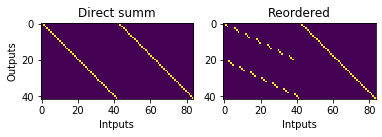


Model file to add M2 RBM from FEM and from the Positioner saved as add_M2_Pos_FEM.yaml 


In [12]:

# Flag to perform M2 RBM reordering (just the first 42 entries are reordered)
reorder_M2RBM = True

# Matrix to summ the inputs
ssD = np.hstack((np.eye(42),np.eye(42)))
if reorder_M2RBM:
    QTxyz = np.kron(np.eye(7), np.hstack((np.eye(3), np.zeros((3,3)))))
    QRxyz = np.kron(np.eye(7), np.hstack((np.zeros((3,3)), np.eye(3))))    
    ssD = np.hstack((np.vstack((QTxyz,QRxyz)),np.eye(42)))
    
plt.subplot(1,2,1)
plt.imshow(np.hstack((np.eye(42),np.eye(42))))
plt.ylabel('Outputs'), plt.xlabel('Intputs'), plt.title('Direct summ')
plt.subplot(1,2,2)
plt.imshow(ssD), plt.xlabel('Intputs'), plt.title('Reordered')
plt.show()

add_M2_Pos_FEM_dt = {'System' :
               {'sampling time': gmt_Ts.tolist(), #second ,
                'parameters': {'A': np.zeros((1, 1)).tolist(),
                               'B': np.zeros((1, 84)).tolist(),
                               'C': np.zeros((42, 1)).tolist(),
                               'D': ssD.tolist()}
               }}
add_M2_Pos_FEM_file = 'add_M2_Pos_FEM.yaml'

if True:
    # Save SS model file to add M2 RBM from FEM and from the Positioner
    with open(add_M2_Pos_FEM_file,'w') as f:
        y.dump(add_M2_Pos_FEM_dt,f)   
    print('\nModel file to add M2 RBM from FEM and from the Positioner saved as %s ' %add_M2_Pos_FEM_file)

### State-space model to add the AcO BM corrections into the SA forces

Unnecessary if driver `M1SA_F_Control.so` is available.

In [13]:
# filepath = '/Users/rromano/Workspace/GMTDatafiles/20200319 Rodrigo k6rot 100000 c/'
# filename = os.path.join(filepath,'m1BM2F.mat')
# m1BM2F = spio.loadmat(filename)['m1BM2F']

# n_u1, n_u2 = m1BM2F.shape[0], m1BM2F.shape[1]

# add_AcO_F_dt = {'System' :
#                {'sampling time': gmt_Ts.tolist(), #second ,
#                 'parameters': {'A': np.zeros((1, 1)).tolist(),
#                                'B': np.zeros((1, n_u1+n_u2)).tolist(),
#                                'C': np.zeros((n_u1, 1)).tolist(),
#                                'D': np.hstack((np.eye(n_u1),m1BM2F)).tolist()}
#                }}
# add_AcO_F_file = 'add_AcO_F.pickle'

# if False:
#     # Save SS model file to add the AcO BM corrections into the SA forces
#     with open(add_AcO_F_file,'wb') as f:
#         pickle.dump(add_AcO_F_dt,f)   
#     print('Model file to add the AcO BM corrections into the SA forces saved as %s ' %add_AcO_F_file)


### M2 offload 

In [14]:
# Averaging filter corner frequency [rad/s]
wc = 2*np.pi
# CT TF
ctM2offAvgTF = signal.TransferFunction([1], [1/wc, 1])
M2offAvgTF = signal.cont2discrete((ctM2offAvgTF.num,ctM2offAvgTF.den), dt=5.0e-3, method='backward_diff')
print('G_off(z):',M2offAvgTF[0][0],M2offAvgTF[1],'\n Ts:',M2offAvgTF[2])

M2offAvgTF_dt = {'System' :{
    'sampling time': M2offAvgTF[2], 
    'parameters': { 'num': M2offAvgTF[0][0].tolist(),
                    'denom': M2offAvgTF[1][:].tolist()}
               }}

filename = 'm2offloadAvgTF.yaml'
if True:
    # Save M2 Positioner (ad hoc) dynamic model yaml file
    with open(filename,'w') as f:
        y.dump(M2offAvgTF_dt, f)
    print('M2 offload averaging filter file saved as %s ' %filename)

G_off(z): [0.03045903 0.        ] [ 1.         -0.96954097] 
 Ts: 0.005
M2 offload averaging filter file saved as m2offloadAvgTF.yaml 


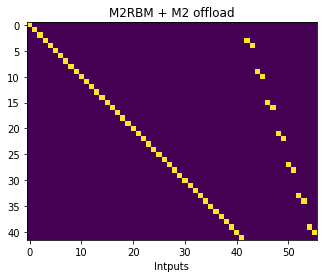


Model file to add M2 offload commands saved as add_M2offload_cmd.yaml 


In [15]:
# Matrix to summ the inputs
K_14_to_42 = np.kron(np.eye(7), np.vstack((np.zeros((3,2)), np.eye(2), np.zeros((1,2)) )))
ssD = np.hstack(( np.eye(42), K_14_to_42 ))
    
plt.imshow(ssD), plt.xlabel('Intputs'), plt.title('M2RBM + M2 offload')
plt.show()

add_M2offload_dt = {'System' :
               {'sampling time': 1.0, #second ,
                'parameters': {'A': np.zeros((1, 1)).tolist(),
                               'B': np.zeros((1, 42+14)).tolist(),
                               'C': np.zeros((42, 1)).tolist(),
                               'D': ssD.tolist()}
               }}
filename = 'add_M2offload_cmd.yaml'

if True:
    # Save SS model file to add M2 offload commands
    with open(filename,'w') as f:
        y.dump(add_M2offload_dt,f)   
    print('\nModel file to add M2 offload commands saved as %s ' %filename)

### AcO smoothing filter

In [16]:
# 2nd order TF parameters
wn = 2*np.pi
zeta = 1.0
Ts = 0.05
# CT TF
ctTF = signal.TransferFunction([wn**2], [1, 2*zeta*wn, wn**2])
dtTF = signal.cont2discrete((ctTF.num,ctTF.den), dt=Ts, method='zoh')
print('G(z):',dtTF[0][0][1:],dtTF[1],'\n Ts:',dtTF[2])

TF_dt = {'System' :{
    'sampling time': dtTF[2], 
    'parameters': { 'num': dtTF[0][0][1:].tolist(),
                    'denom': dtTF[1][:].tolist()}
               }}

# Save yaml files
smoothing_yaml_file = 'mXRBM_IS_f.yaml'
if True:
    for k in range(2):
        filename = 'm%d%s'%(k+1,smoothing_yaml_file[2:])
        with open(filename,'w') as f:
            y.dump(TF_dt, f)
        print('Smoothing file saved as %s'%filename)    
else:
    t, x = signal.step(ctTF)
    dt_sys = signal.dlti(TF_dt['System']['parameters']['num'],TF_dt['System']['parameters']['denom']
        ,dt=TF_dt['System']['sampling time'])
    td, yd = signal.dstep(dt_sys)
    plt.plot(t, x, label='CT TF')
    plt.plot(td, yd[0],'.--',label='DT Approx')
    plt.xlim([0,1.5])
    plt.xlabel('Time (s)'), plt.ylabel('Amplitude')
    plt.title('Step response for Input Shaping')
    plt.legend(), plt.grid()


G(z): [0.04013454 0.03254817] [ 1.         -1.46080538  0.53348809] 
 Ts: 0.05
Smoothing file saved as m1RBM_IS_f.yaml
Smoothing file saved as m2RBM_IS_f.yaml
